In [1]:
%matplotlib inline
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook
from sklearn.svm import SVR

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc');
octave.addpath(eeglab_path + 'popfunc');
octave.addpath(eeglab_path + 'adminfunc');
octave.addpath(eeglab_path + 'sigprocfunc');
octave.addpath(eeglab_path + 'miscfunc');

In [3]:
experiment = 'data/original/*/*'
meps = sorted(glob.glob(experiment + '/mep/*/*.txt'))
mep_present = len(meps) > 0
eegs = sorted(glob.glob(experiment + '/eeg/*/clean-prestimulus.set'))
eeg_present = len(eegs) > 0
cmaps = sorted(glob.glob(experiment + '/cmap/*.xlsx'))
cmap_present = len(cmaps) > 0
all_present = mep_present and eeg_present and cmap_present
print(all_present)

True


In [4]:
print('EEG count: ' + str(len(eegs)))
print('MEP count: ' + str(len(meps)))
print('CMAP count: ' + str(len(cmaps)))

EEG count: 44
MEP count: 77
CMAP count: 22


In [5]:
eegs

['data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub05/exp02/eeg/SP 120RMT r2/clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP

In [6]:
eegs = [
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
    'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set', NO CMAP
#     'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub12/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub13/exp01/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub14/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r3/clean-prestimulus.set'
]

# Read and process EEG

In [7]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, -20, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

# Calculate EEG area.
def calculate_eeg_area(epoch_df, sf=2048):
    y = epoch_df.drop('time', axis=1).mean(axis=1)
    b2, a2 = signal.butter(4, 200/(sf/2), btype='lowpass')
    envelope = signal.filtfilt(b2, a2, np.abs(y))
    area = np.trapz(envelope, epoch_df['time'].values)
    return area

# Calculate EEG frequency.
def calculate_eeg_frequency(channel):
    sf = 2048
    win = 4 * sf
    freqs, psd = signal.welch(channel, sf, nperseg=win)
    return freqs, psd

def calculate_eeg_max_amplitude(epoch_df):
    avg = epoch_df.mean(axis=1)
    return np.max(avg.values)

def band_max(freq, psd, interval):
    indices = []
    for el in freq:
        indices.append(el in interval)
    freq = freq[indices]
    psd = psd[indices]
    if (len(psd) == 0):
        return 0, 0
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

def filter_electrodes(trial, which='all'):
    time_column = trial['time']
    if which == 'ltm1':
        channel_names = ['FC5','FC1','C3','CP5','CP1','FC3','C5','C1','CP3']
    elif which == 'rtm1':
        channel_names = ['FC6','FC2','C4','CP6','CP2','FC4','C6','C2','CP4']
    elif which == 'central':
        channel_names = ['Fz','FCz','Cz','F1','FC1','C1','C2','FC2','F2']
    else:
        channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
    trial = trial[channel_names]
    trial['time'] = time_column
    return trial

def read_wavelets(sub, exp, run, epoch_num):
    path = 'wavelets/' + sub + '-' + exp + '-' + run + '-' + str(epoch_num)
    with open(path + '-central.pickle', 'rb') as f:
        central = pickle.load(f)
    with open(path + '-ltm1.pickle', 'rb') as f:
        ltm1 = pickle.load(f)
    with open(path + '-rtm1.pickle', 'rb') as f:
        rtm1 = pickle.load(f)
    with open(path + '-all.pickle', 'rb') as f:
        all_channels = pickle.load(f)
    return all_channels, ltm1, rtm1, central

def wavelet_band_max(df, interval):
    indices = []
    for el in (df.index * 1000):
        indices.append(el in interval)
    df = df[indices]
    if (df.shape[0] == 0):
        return 0, 0, 0, 0
    return df.mean(axis=1).max(), df.mean(axis=1).argmax() * 1000, df.mean(axis=0).max(), df.mean(axis=0).argmax()

def normalize_image(image, mx=1, mn=0):
    std = (image - image.min()) / (image.max() - image.min())
    return std * (mx - mn) + mn

# Read features file

In [8]:
features_filename = '55-features-v1.xlsx'

In [9]:
df = pd.read_excel(features_filename, index_col=0)

p1 = np.percentile(df['mep_category_cmap'], 50)
cat = np.ones(len(df['mep_category_cmap'])) * (df['mep_category_cmap'] > p1)
df['mep_category_cmap_across_subjects'] = cat

# Add all wavelets

In [10]:
start_time = -500

In [12]:
wt_large_all_all, wt_large_ltm1_all, wt_large_rtm1_all, wt_large_central_all, wt_small_all_all, wt_small_ltm1_all, wt_small_rtm1_all, wt_small_central_all = np.zeros((52, 1024)), np.zeros((52, 1024)), np.zeros((52, 1024)), np.zeros((52, 1024)), np.zeros((52, 1024)), np.zeros((52, 1024)), np.zeros((52, 1024)), np.zeros((52, 1024))
wt_large_all_all_avg, wt_large_ltm1_all_avg, wt_large_rtm1_all_avg, wt_large_central_all_avg, wt_small_all_all_avg, wt_small_ltm1_all_avg, wt_small_rtm1_all_avg, wt_small_central_all_avg = np.zeros((52, 1024)), np.zeros((52, 1024)), np.zeros((52, 1024)), np.zeros((52, 1024)), np.zeros((52, 1024)), np.zeros((52, 1024)), np.zeros((52, 1024)), np.zeros((52, 1024))
        
for idx, epoch in tqdm_notebook(df.iterrows(), total=df.shape[0]):
    wt_all, wt_ltm1, wt_rtm1, wt_central = read_wavelets(epoch['sub'], epoch['exp'], epoch['run'], epoch['epoch'])

    # Drop last 9 rows (freq 0 to 2Hz)
    wt_all = wt_all.drop(wt_all.tail(21).index)
    wt_ltm1 = wt_ltm1.drop(wt_ltm1.tail(21).index)
    wt_rtm1 = wt_rtm1.drop(wt_all.tail(21).index)
    wt_central = wt_central.drop(wt_all.tail(21).index)

    # Take only last 100ms - 0
#     wt_all = wt_all.loc[:, wt_all.columns.isin(wt_all.columns[wt_all.columns > (start_time/1000)])]
#     wt_ltm1 = wt_ltm1.loc[:, wt_ltm1.columns.isin(wt_ltm1.columns[wt_ltm1.columns > (start_time/1000)])]
#     wt_rtm1 = wt_rtm1.loc[:, wt_rtm1.columns.isin(wt_rtm1.columns[wt_rtm1.columns > (start_time/1000)])]
#     wt_central = wt_central.loc[:, wt_central.columns.isin(wt_central.columns[wt_central.columns > (start_time/1000)])]

    if (epoch['mep_category_cmap_across_subjects'] == 1):
        wt_large_all_all = np.add(wt_large_all_all, normalize_image(wt_all))
        wt_large_ltm1_all = np.add(wt_large_ltm1_all, normalize_image(wt_ltm1))
        wt_large_rtm1_all = np.add(wt_large_rtm1_all, normalize_image(wt_rtm1))
        wt_large_central_all = np.add(wt_large_central_all, normalize_image(wt_central))
        
#         wt_large_all_all = np.add(np.add(wt_all_all, wt_all), -noise_wt_large_all_all)
#         wt_large_ltm1_all = np.add(np.add(wt_ltm1_all, wt_ltm1), -noise_wt_large_ltm1_all)
#         wt_large_rtm1_all = np.add(np.add(wt_rtm1_all, wt_rtm1), -noise_wt_large_rtm1_all)
#         wt_large_central_all = np.add(np.add(wt_central_all, wt_central), -noise_wt_large_central_all)
        
#         wt_large_all_all_avg = np.add(np.add(wt_large_all_all_avg, wt_all)/2, -noise_wt_large_all_all_avg)
#         wt_large_ltm1_all_avg = np.add(np.add(wt_large_ltm1_all_avg, wt_ltm1)/2, -noise_wt_large_ltm1_all_avg)
#         wt_large_rtm1_all_avg = np.add(np.add(wt_large_rtm1_all_avg, wt_rtm1)/2, -noise_wt_large_rtm1_all_avg)
#         wt_large_central_all_avg = np.add(np.add(wt_large_central_all_avg, wt_central)/2, -noise_wt_large_central_all_avg)

#         wt_large_all_all_avg = np.add(np.add(wt_large_all_all_avg, wt_all)/2, -noise_wt_large_all_all_avg)
#         wt_large_ltm1_all_avg = np.add(np.add(wt_large_ltm1_all_avg, wt_ltm1)/2, -noise_wt_large_ltm1_all_avg)
#         wt_large_rtm1_all_avg = np.add(np.add(wt_large_rtm1_all_avg, wt_rtm1)/2, -noise_wt_large_rtm1_all_avg)
#         wt_large_central_all_avg = np.add(np.add(wt_large_central_all_avg, wt_central)/2, -noise_wt_large_central_all_avg)
    else:
        wt_small_all_all = np.add(wt_small_all_all, normalize_image(wt_all))
        wt_small_ltm1_all = np.add(wt_small_ltm1_all, normalize_image(wt_ltm1))
        wt_small_rtm1_all = np.add(wt_small_rtm1_all, normalize_image(wt_rtm1))
        wt_small_central_all = np.add(wt_small_central_all, normalize_image(wt_central))
        
#         wt_small_all_all = np.add(np.add(wt_all_all, wt_all), -noise_wt_small_all_all)
#         wt_small_ltm1_all = np.add(np.add(wt_ltm1_all, wt_ltm1), -noise_wt_small_ltm1_all)
#         wt_small_rtm1_all = np.add(np.add(wt_rtm1_all, wt_rtm1), -noise_wt_small_rtm1_all)
#         wt_small_central_all = np.add(np.add(wt_central_all, wt_central), -noise_wt_small_central_all)
        
#         wt_small_all_all_avg = np.add(np.add(wt_small_all_all_avg, wt_all)/2, -noise_wt_large_all_all_avg)
#         wt_small_ltm1_all_avg = np.add(np.add(wt_small_ltm1_all_avg, wt_ltm1)/2, -noise_wt_large_ltm1_all_avg)
#         wt_small_rtm1_all_avg = np.add(np.add(wt_small_rtm1_all_avg, wt_rtm1)/2, -noise_wt_large_rtm1_all_avg)
#         wt_small_central_all_avg = np.add(np.add(wt_small_central_all_avg, wt_central)/2, -noise_wt_large_central_all_avg)

#     if (idx != 0) and (1400 % idx) == 5:
#     if idx < 10:
#         print(idx)
#         plt.figure()
#         sns.heatmap(wt_large_ltm1_all)

In [13]:
noise_wt_large_all_all, noise_wt_large_ltm1_all, noise_wt_large_rtm1_all, noise_wt_large_central_all, noise_wt_small_all_all, noise_wt_small_ltm1_all, noise_wt_small_rtm1_all, noise_wt_small_central_all = wt_large_all_all/df.shape[0], wt_large_ltm1_all/df.shape[0], wt_large_rtm1_all/df.shape[0], wt_large_central_all/df.shape[0], wt_small_all_all/df.shape[0], wt_small_ltm1_all/df.shape[0], wt_small_rtm1_all/df.shape[0], wt_small_central_all/df.shape[0]
# noise_wt_large_all_all_avg, noise_wt_large_ltm1_all_avg, noise_wt_large_rtm1_all_avg, noise_wt_large_central_all_avg, noise_wt_small_all_all_avg, noise_wt_small_ltm1_all_avg, noise_wt_small_rtm1_all_avg, noise_wt_small_central_all_avg = wt_large_all_all_avg, wt_large_ltm1_all_avg, wt_large_rtm1_all_avg, wt_large_central_all_avg, wt_small_all_all_avg, wt_small_ltm1_all_avg, wt_small_rtm1_all_avg, wt_small_central_all_avg

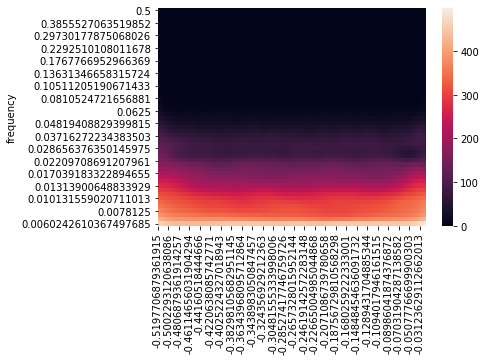

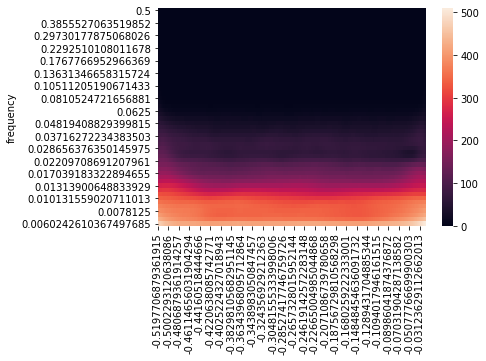

In [14]:
plt.figure()
sns.heatmap(wt_large_ltm1_all)

plt.figure()
sns.heatmap(wt_small_ltm1_all)

In [15]:
wt_large_ltm1_all.columns = np.round(wt_large_ltm1_all.columns, 3)
wt_small_ltm1_all.columns = np.round(wt_small_ltm1_all.columns, 3)
wt_large_ltm1_all.index = np.round(wt_large_ltm1_all.index*1000, 2)
wt_small_ltm1_all.index = np.round(wt_small_ltm1_all.index*1000, 2)

# LtM1
noise_wt_large_ltm1_all.columns = np.round(noise_wt_large_ltm1_all.columns, 3)
noise_wt_small_ltm1_all.columns = np.round(noise_wt_small_ltm1_all.columns, 3)
noise_wt_large_ltm1_all.index = np.round(noise_wt_large_ltm1_all.index*1000, 2)
noise_wt_small_ltm1_all.index = np.round(noise_wt_small_ltm1_all.index*1000, 2)

# All
noise_wt_large_all_all.columns = np.round(noise_wt_large_all_all.columns, 3)
noise_wt_small_all_all.columns = np.round(noise_wt_small_all_all.columns, 3)
noise_wt_large_all_all.index = np.round(noise_wt_large_all_all.index*1000, 2)
noise_wt_small_all_all.index = np.round(noise_wt_small_all_all.index*1000, 2)

# RtM1
noise_wt_large_rtm1_all.columns = np.round(noise_wt_large_rtm1_all.columns, 3)
noise_wt_small_rtm1_all.columns = np.round(noise_wt_small_rtm1_all.columns, 3)
noise_wt_large_rtm1_all.index = np.round(noise_wt_large_rtm1_all.index*1000, 2)
noise_wt_small_rtm1_all.index = np.round(noise_wt_small_rtm1_all.index*1000, 2)

# Central
noise_wt_large_central_all.columns = np.round(noise_wt_large_central_all.columns, 3)
noise_wt_small_central_all.columns = np.round(noise_wt_small_central_all.columns, 3)
noise_wt_large_central_all.index = np.round(noise_wt_large_central_all.index*1000, 2)
noise_wt_small_central_all.index = np.round(noise_wt_small_central_all.index*1000, 2)

# Save the data

In [26]:
wt_large_all_all.to_excel('67-large-all-mep-sum.xlsx')

wt_large_all_all, wt_large_ltm1_all, wt_large_rtm1_all, wt_large_central_all, wt_small_all_all, wt_small_ltm1_all, wt_small_rtm1_all, wt_small_central_all 

,-0.52,-0.519,-0.519,-0.518,-0.518,-0.517,-0.517,-0.516,-0.516,-0.515,...,-0.024,-0.024,-0.023,-0.023,-0.022,-0.022,-0.021,-0.021,-0.02,-0.02
frequency,,,,,,,,,,,,,,,,,,,,,
500.00,1.767294,0.774818,0.090418,0.003924,0.000053,0.000000,0.000000,2.114487e-11,2.522142e-10,1.396688e-10,...,7.939312e-11,1.392680e-10,1.875706e-11,0.000000,0.000000,0.000000,0.000084,0.003401,0.064001,0.356748
458.50,1.324966,0.559687,0.139910,0.065693,0.017826,0.002419,0.000179,7.560675e-06,1.991604e-07,6.139408e-09,...,3.978511e-09,5.533067e-08,2.308691e-06,0.000062,0.001006,0.009620,0.051924,0.148830,0.234488,0.334559
420.45,1.137084,0.604133,0.323395,0.185760,0.056100,0.009392,0.000953,6.192514e-05,2.659218e-06,9.370110e-08,...,4.620026e-08,1.035926e-06,2.411141e-05,0.000385,0.004084,0.027929,0.116881,0.274497,0.334294,0.300692
385.55,1.129035,0.838954,0.646371,0.395892,0.136815,0.029158,0.004168,4.185533e-04,3.006061e-05,1.591489e-06,...,5.212853e-07,9.184382e-06,1.321726e-04,0.001379,0.010267,0.053147,0.180989,0.365432,0.382018,0.272971
353.55,1.232196,1.217840,1.122989,0.741456,0.300290,0.082308,0.016405,2.456569e-03,2.799855e-04,2.459814e-05,...,3.867574e-06,4.715881e-05,4.607388e-04,0.003432,0.019304,0.080223,0.232626,0.418228,0.390723,0.249226


In [ ]:
wt_large_all_all, wt_large_ltm1_all, wt_large_rtm1_all, wt_large_central_all, wt_small_all_all, wt_small_ltm1_all, wt_small_rtm1_all, wt_small_central_all

# LtM1

Text(0.5, 1, 'Difference of mean normalized power')

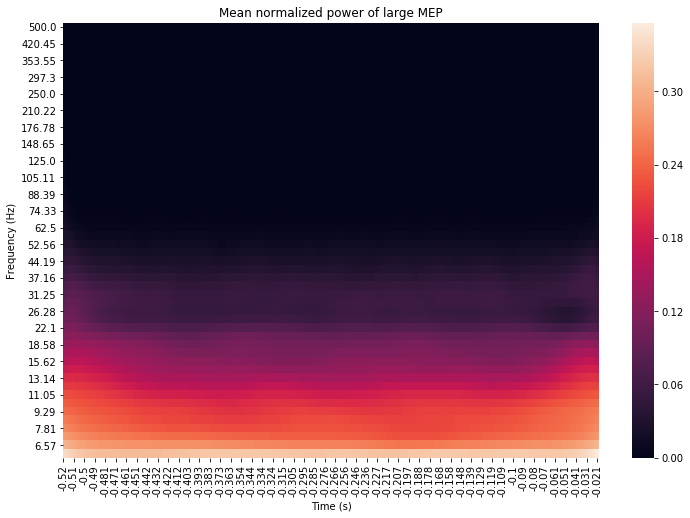

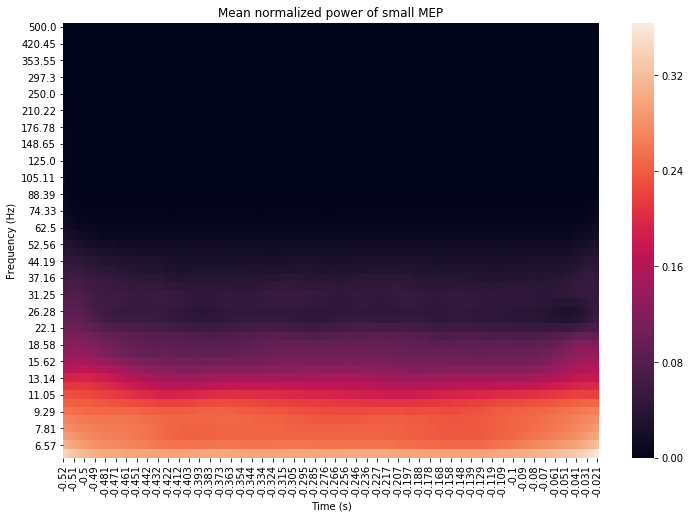

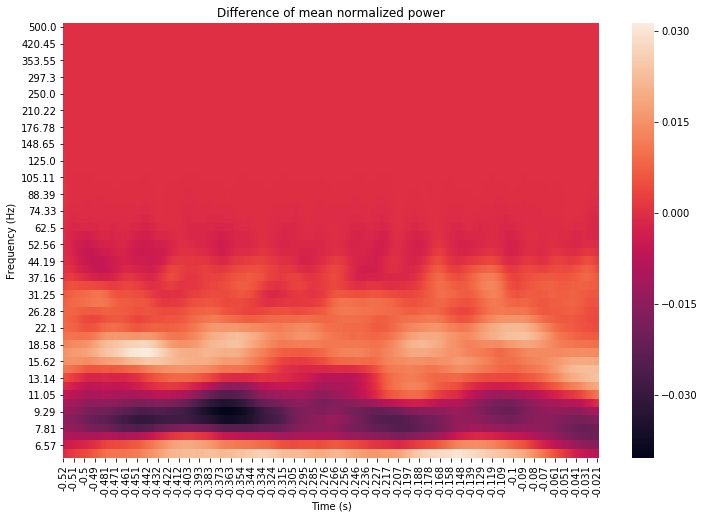

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(noise_wt_large_ltm1_all)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Mean normalized power of large MEP')

plt.figure(figsize=(12,8))
sns.heatmap(noise_wt_small_ltm1_all)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Mean normalized power of small MEP')

plt.figure(figsize=(12,8))
sns.heatmap(np.add(noise_wt_large_ltm1_all, -noise_wt_small_ltm1_all))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Difference of mean normalized power')

# All electrodes

Text(0.5, 1, 'Difference of mean normalized power')

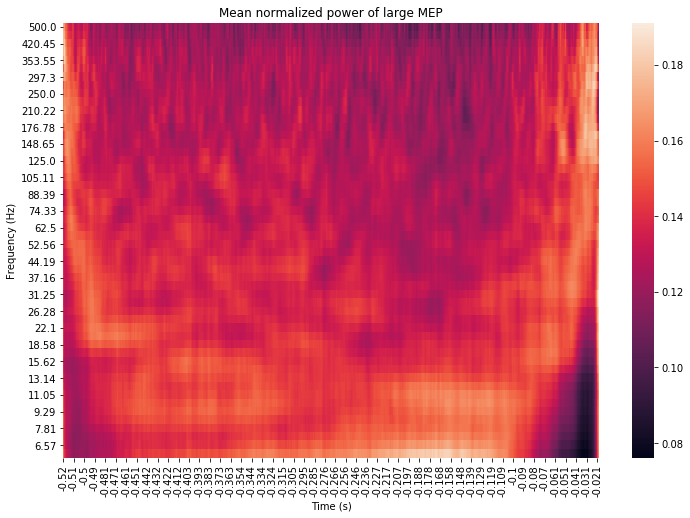

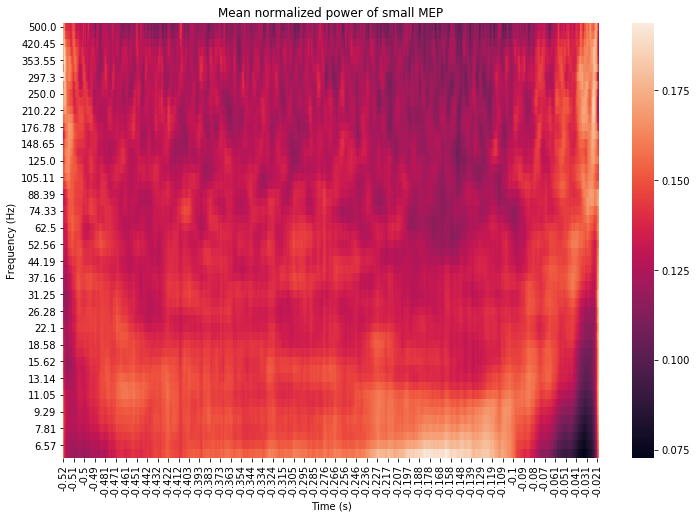

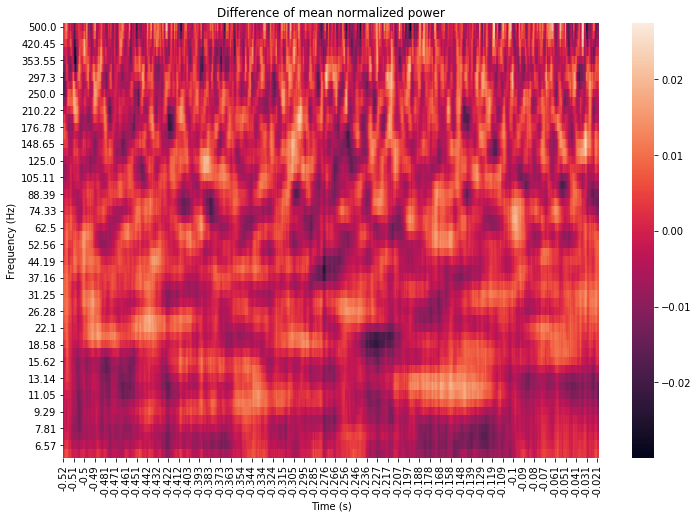

In [22]:
plt.figure(figsize=(12,8))
sns.heatmap(noise_wt_large_all_all)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Mean normalized power of large MEP')

plt.figure(figsize=(12,8))
sns.heatmap(noise_wt_small_all_all)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Mean normalized power of small MEP')

plt.figure(figsize=(12,8))
sns.heatmap(np.add(noise_wt_large_all_all, -noise_wt_small_all_all))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Difference of mean normalized power')

# Correlation

In [18]:
start_time_millis = -25
end_time_millis = -20
start_freq = 8
end_freq = 20
df_corr = []
        
for idx, epoch in tqdm_notebook(df.iterrows(), total=df.shape[0]):
    wt_all, wt_ltm1, wt_rtm1, wt_central = read_wavelets(epoch['sub'], epoch['exp'], epoch['run'], epoch['epoch'])

    # Take 6-50Hz frequencies.
#     wt_all = wt_all[(wt_all.index * 1000 > 6) * (wt_all.index * 1000 < 22)]
    wt_ltm1 = wt_ltm1[(wt_ltm1.index * 1000 > start_freq) * (wt_ltm1.index * 1000 < end_freq)]
#     wt_rtm1 = wt_rtm1[(wt_rtm1.index * 1000 > 6) * (wt_rtm1.index * 1000 < 22)]
#     wt_central = wt_central[(wt_central.index * 1000 > 6) * (wt_central.index * 1000 < 22)]

    # Take only last -100ms to -20ms.
#     wt_all = wt_all.loc[:, wt_all.columns.isin(wt_all.columns[(wt_all.columns >= (start_time_sec/1000)) * (wt_all.columns <= (end_time_sec/1000))])]
    wt_ltm1 = wt_ltm1.loc[:, wt_ltm1.columns.isin(wt_ltm1.columns[(wt_ltm1.columns >= (start_time_millis/1000)) * (wt_ltm1.columns <= (end_time_millis/1000))])]
    
#     wt_rtm1 = wt_rtm1.loc[:, wt_rtm1.columns.isin(wt_rtm1.columns[(wt_rtm1.columns >= (start_time_sec/1000)) * (wt_rtm1.columns <= (end_time_sec/1000))])]
#     wt_central = wt_central.loc[:, wt_central.columns.isin(wt_central.columns[(wt_central.columns >= (start_time_sec/1000)) * (wt_central.columns <= (end_time_sec/1000))])]


    wt_ltm1.columns = np.round(wt_ltm1.columns, 3)
    wt_ltm1.index = np.round(wt_ltm1.index*1000, 2)
    wt_ltm1 = normalize_image(wt_ltm1)


    df_corr_el = {
        'mep_category_absolute': epoch['mep_category_absolute'],
        'mep_category_cmap_across_subjects': epoch['mep_category_cmap_across_subjects'],
        'mep_size': epoch['mep_size'],
        'mep_category_percentile': epoch['mep_category_percentile']
    }
    i = 0
    
    for time, column in wt_ltm1.iteritems():
        for freq, row in pd.DataFrame(column).iterrows():
            df_corr_el['power_' + str(time) + '_' + str(freq)] = row.values[0]
    df_corr.append(df_corr_el)

In [23]:
df_flat = pd.DataFrame(df_corr)
df_flat.shape

(1400, 64)

In [24]:
df_flat.head()

,mep_category_absolute,mep_category_cmap_across_subjects,mep_category_percentile,mep_size,power_-0.021_10.13,power_-0.021_11.05,power_-0.021_12.05,power_-0.021_13.14,power_-0.021_14.33,power_-0.021_15.62,...,power_-0.02_10.13,power_-0.02_11.05,power_-0.02_12.05,power_-0.02_13.14,power_-0.02_14.33,power_-0.02_15.62,power_-0.02_17.04,power_-0.02_18.58,power_-0.02_8.52,power_-0.02_9.29
0,2,1.0,2,2.555237,0.874702,0.549869,0.234529,0.096317,0.105856,0.112695,...,0.867629,0.543169,0.234404,0.100719,0.108238,0.110881,0.053088,0.000000,0.945592,1.000000
1,1,1.0,1,0.894165,0.993974,0.830988,0.609908,0.368027,0.175916,0.046930,...,0.988419,0.821719,0.599810,0.359160,0.169613,0.044092,0.000000,0.021201,0.841507,1.000000
2,1,1.0,0,0.600739,0.881853,0.975518,1.000000,0.878572,0.657223,0.391221,...,0.893098,0.982098,1.000000,0.872394,0.648549,0.383317,0.147858,0.000000,0.584326,0.767225
3,1,1.0,0,0.636902,0.072970,0.220613,0.332940,0.371649,0.482889,0.737865,...,0.075253,0.224629,0.338233,0.380621,0.497492,0.751134,0.955221,1.000000,0.057466,0.000000
4,1,1.0,0,0.597992,0.245452,0.042515,0.000000,0.080210,0.219221,0.369683,...,0.242267,0.040815,0.000000,0.080767,0.218899,0.366500,0.470095,0.500663,1.000000,0.591664


Text(0.5, 1.05, 'Correlation Matrix')

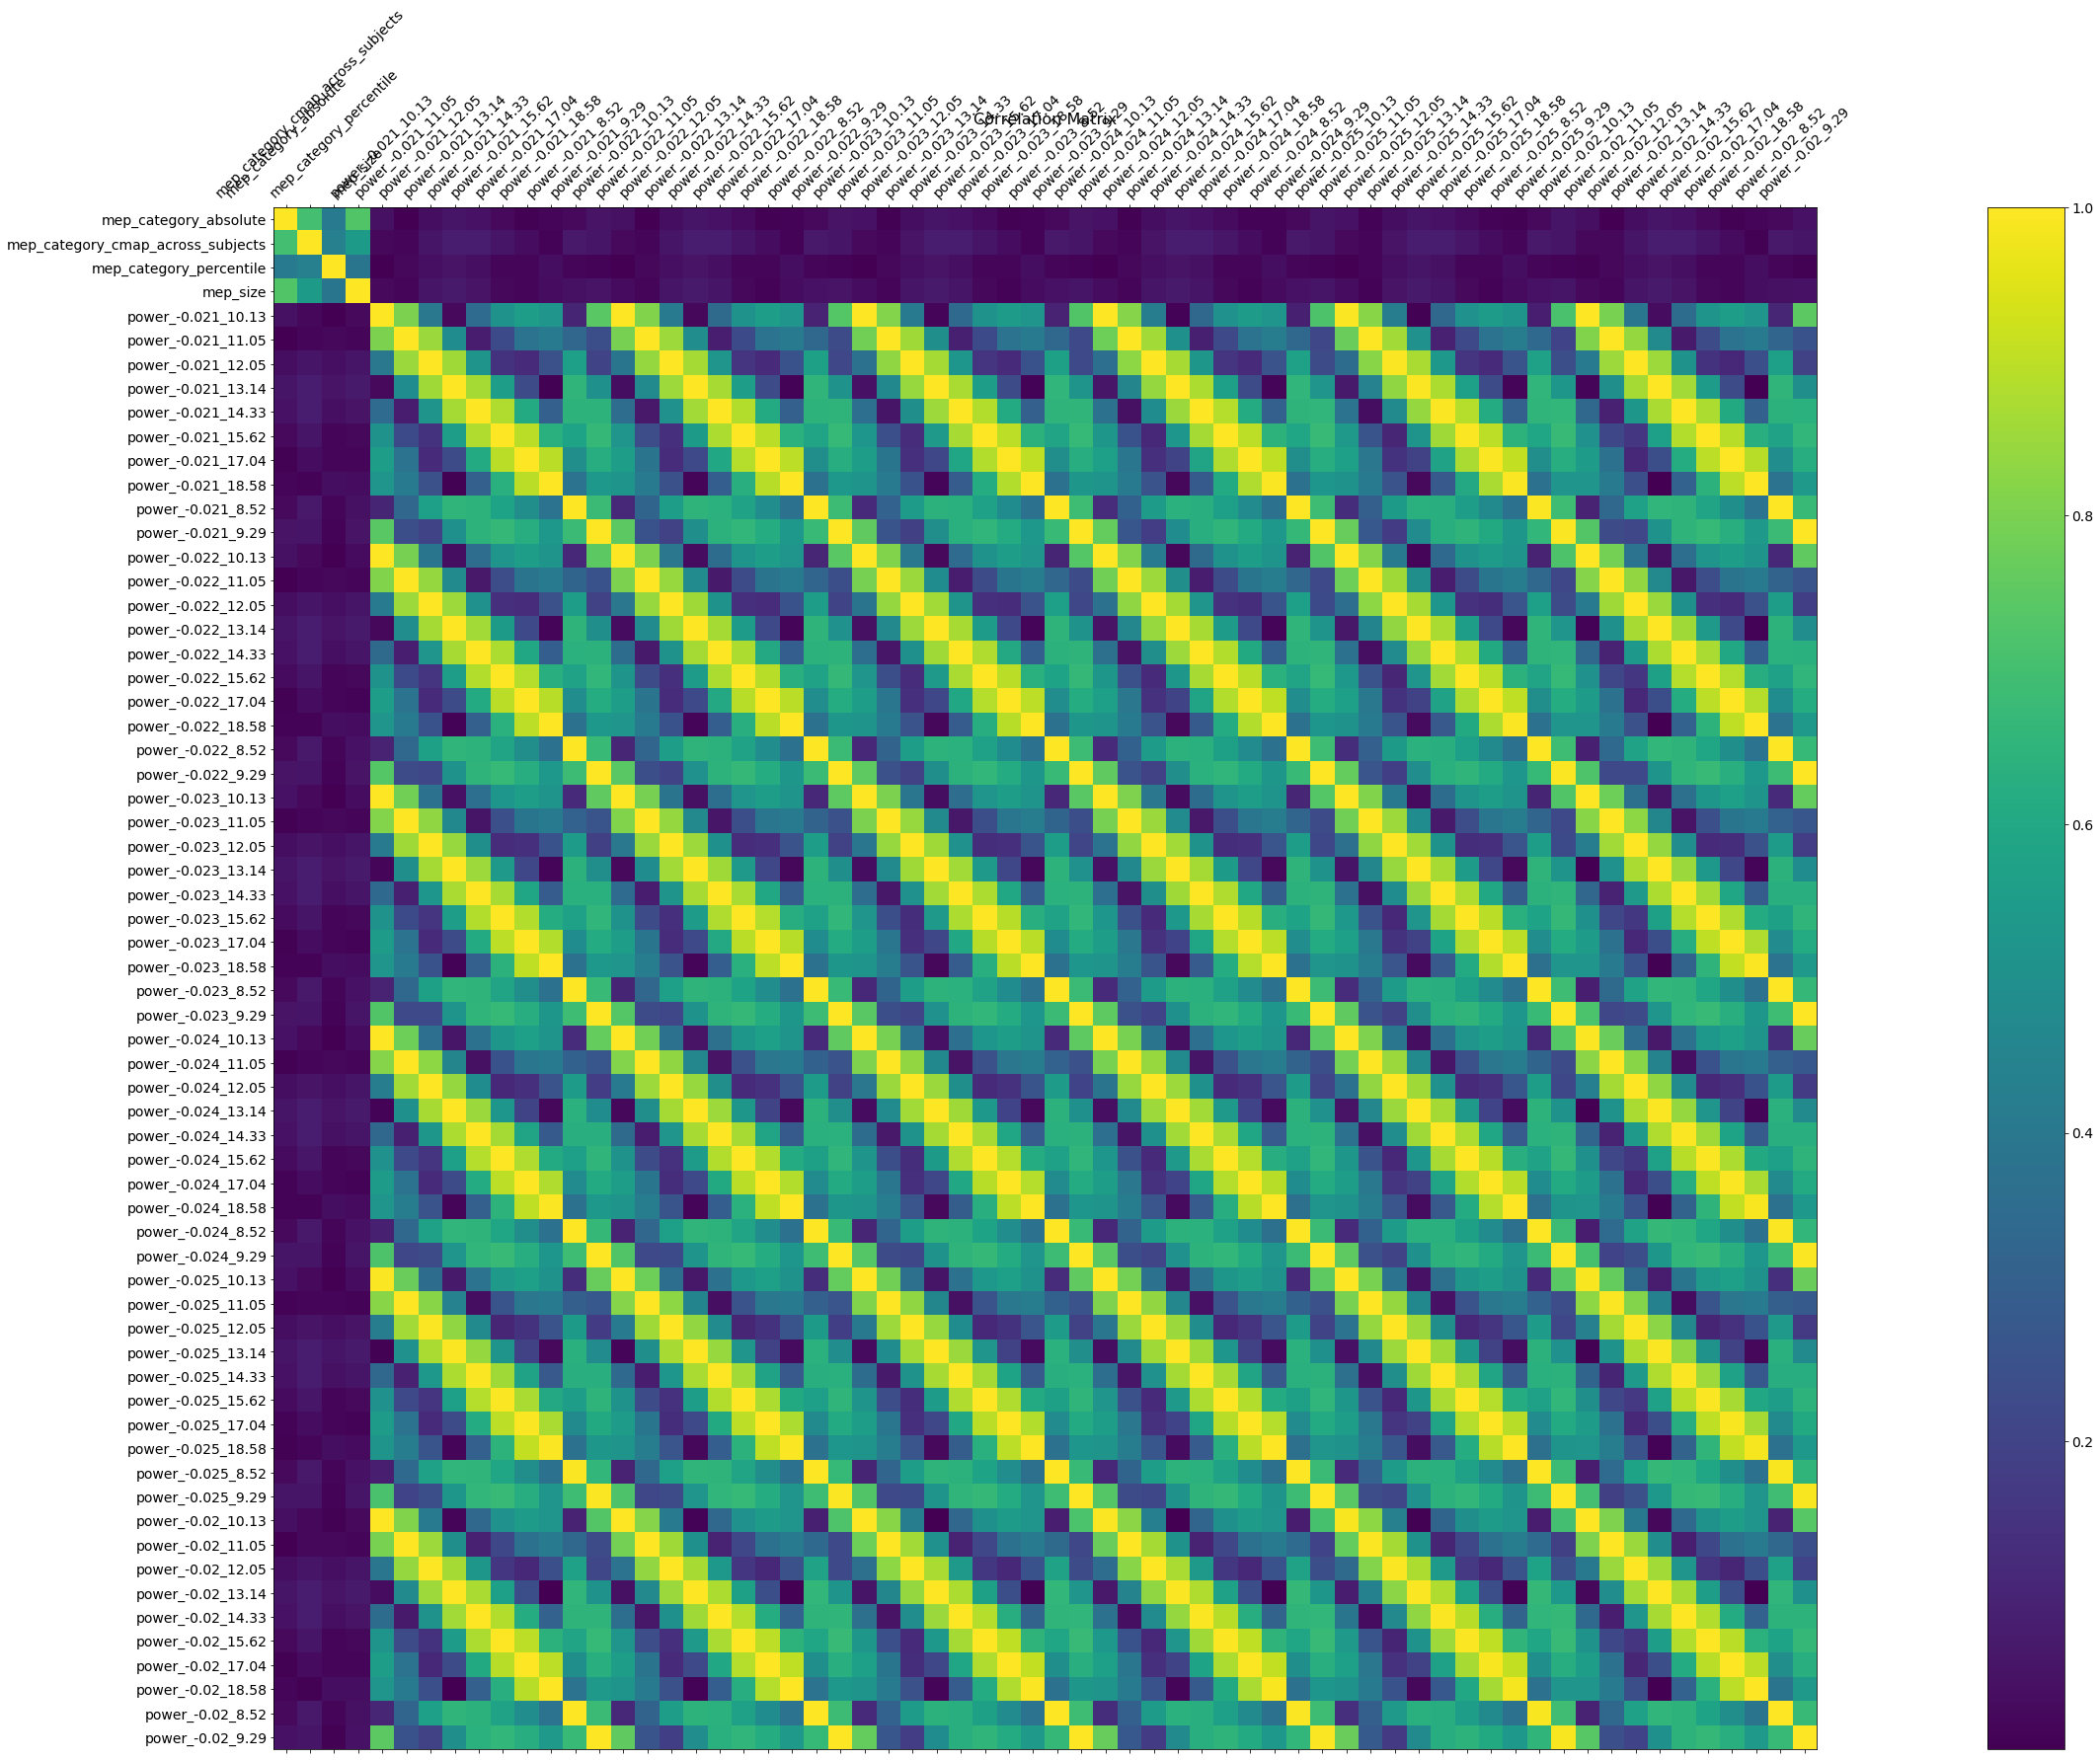

In [25]:
f = plt.figure(figsize=(62, 28))
plt.matshow(np.abs(df_flat.corr()), fignum=f.number)
plt.xticks(range(df_flat.shape[1]), df_flat.columns, fontsize=14, rotation=45)
plt.yticks(range(df_flat.shape[1]), df_flat.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# Prepare df for t test